In [26]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import os
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/exp1')

In [2]:
set_seed = True

seed = 314159
if set_seed:
    print("Setting seed for the experiment")
    # Set seed for CPU and all GPUs (if available)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

Setting seed for the experiment


In [3]:
class TrafficDataset(Dataset):
    def __init__(self, directory,label_directory):
        
        self.files = [os.path.join(directory, f) for f in sorted(os.listdir(directory))] #[0:100]
        self.yfiles= [os.path.join(label_directory, f) for f in sorted(os.listdir(label_directory))] #[0:100]
        self.num_files = len(self.files)
        
        self.total_sequences = self.num_files # * self.sequences_per_file
        
    def __len__(self):
        return self.total_sequences
    
    def __getitem__(self, index):
        
        file_index = index 
        
        data = np.load(self.files[file_index]) #Loads the file which contains our desired sequence
        label_data = np.load(self.yfiles[file_index])

        sequence = np.transpose(data, (2, 0, 1)) # To orient in the dimension with 3 channels being first
        
        return torch.tensor(sequence, dtype=torch.float32),torch.tensor(label_data, dtype=torch.float32)

In [4]:
print(f"Is CUDA available : {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Is CUDA available : True


In [5]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        # Assuming the input shape is (batch_size, 3, 300, 42) after reshaping
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=1, padding=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding=2)
        self.fc1 = nn.Linear(1,128)
        self.fc2 = nn.Linear(128, 64)  
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 13)# Output layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)  # Flatten starting from the 2nd dimension
            # Dynamically determine 'in_features' for the first fully connected layer
        if self.fc1.in_features == 1:  # Check if the placeholder value is still there
            num_features = x.shape[1]
            self.fc1 = nn.Linear(num_features, 128).to(x.device)  # Replace with the correct in_features
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x= self.fc4(x)
        return x

In [6]:
# Train - Test splits
features_path = r"data/dataset1/features"
labels_path = r"data/dataset1/labels"
dataset = TrafficDataset(features_path, labels_path)

# Calculate the lengths of splits
total_size = len(dataset)
train_size = int(0.9 * total_size)
test_size = total_size - train_size

print(f"Train size is : {train_size}")
print(f"Test size is : {test_size}")

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for both datasets
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0) # num of workers = 0 in windows
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0) # Shuffle is usually False for testing/validation



Train size is : 19438
Test size is : 2160


In [7]:
classes_count_dict = {
    0:0,
    1:0,
    2:0,
    3:0,
    4:0,
    5:0,
    6:0,
    7:0,
    8:0,
    9:0,
    10:0,
    11:0,
    12:0
}

for i,(input,labels) in enumerate(train_dataloader):

    _, labels_indices = torch.max(labels, 1)

    for index in labels_indices:
        # print(int(index.numpy()))
        classes_count_dict[int(index.numpy())]+=1


print(classes_count_dict)
class_counts = []
for key in classes_count_dict.keys():

    class_counts.append(classes_count_dict[key])

weights = 1.0 / torch.tensor(class_counts, dtype=torch.float,device=device)
weights = weights / weights.min()
print(weights)

{0: 468, 1: 564, 2: 471, 3: 632, 4: 461, 5: 411, 6: 610, 7: 239, 8: 1696, 9: 561, 10: 1408, 11: 701, 12: 11216}
tensor([23.9658, 19.8865, 23.8132, 17.7468, 24.3297, 27.2895, 18.3869, 46.9289,
         6.6132, 19.9929,  7.9659, 16.0000,  1.0000], device='cuda:0')


In [8]:
num_epochs  = 50
experiment_no = 2
n_classes = 13

model = CNNClassifier()
loss_function = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model to GPU if available
model.to(device)
correct_predictions_per_class = torch.zeros(n_classes, device=device)
actual_per_class = torch.zeros(n_classes, device=device)

In [9]:
print(f"Device used is {device}")

Device used is cuda


In [10]:
global_step = 0
training_loss_data = [] # Stores total training loss for each epoch
testing_loss_data = [] # Stores total testing loss for each epoch
epochs = []
training_time = 0 # Stores the total training time

In [ ]:
print(f"Training started for {num_epochs} epochs")

for epoch in range(num_epochs):
    
    epochs .append(epoch) 
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    start_time = time.time()
    total_predictions =0
    
    for i, (inputs, labels) in enumerate(train_dataloader):
        
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to the device
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        _, labels_indices = torch.max(labels, 1)
        total_samples += labels.size(0)
        
        predicted = predicted.to(labels_indices.device).long() 
        labels_indices = labels_indices.to(predicted.device).long()

        correct_predictions += (predicted == labels_indices).sum().item()
        total_predictions = total_predictions+32
        
        for class_index in range(n_classes):
            correct_predictions_per_class[class_index] += ((predicted == labels_indices) & (labels_indices == class_index)).sum()
            actual_per_class[class_index] += (labels_indices == class_index).sum()

        if i % 152 == 0:  # Log every 10 batches
            print(f"Epoch {epoch+1}, Batch {i+1}/{len(train_dataloader)}, Partial Loss: {running_loss/(i+1):.4f}, Correct Predictions: {correct_predictions}/{total_predictions}")
            

        global_step+=1
        
    epoch_time = time.time() - start_time
    epoch_loss = running_loss / len(train_dataloader)
    training_loss_data.append(epoch_loss)
    epoch_accuracy = (correct_predictions / total_samples) * 100
    print(f"Epoch {epoch+1} completed in {epoch_time:.2f} seconds.")
    
    print(f"Epoch {epoch+1} Training Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
    writer.add_scalar("Loss/train",epoch_loss, global_step) # Writing to tensorboard
    # Testing phase ---------------------------------------------------------------------------
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No gradients needed for validation
        correct_test_predictions = 0
        total_test_samples = 0
        test_loss = 0
        for test_inputs, test_labels in test_dataloader:
            test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)      
            outputs = model(test_inputs)
            loss = loss_function(outputs, test_labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test_samples += test_labels.size(0)
            _, labels_indices = torch.max(test_labels, 1)

            correct_test_predictions += (predicted == labels_indices).sum().item()
    testing_loss_data.append(test_loss)
    test_accuracy = (correct_test_predictions / total_test_samples) * 100
    print(f"Epoch {epoch+1} Test Accuracy: {test_accuracy:.2f}% \n")

writer.flush()
writer.close()



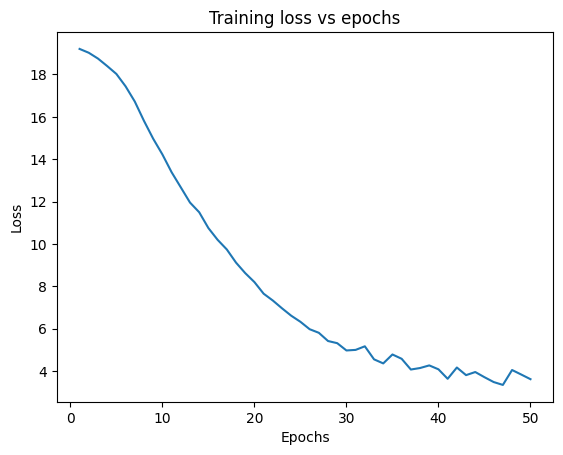

In [16]:
# Training loss vs epochs



plt.plot(epochs,training_loss_data)
plt.title("Training loss vs epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

     

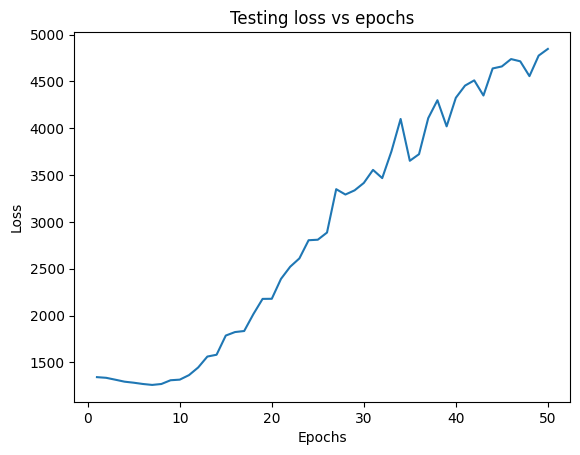

In [17]:
# Testing loss vs epochs
plt.plot(epochs,testing_loss_data)
plt.title("Testing loss vs epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


In [22]:
# Running evaluation on test model again
true_labels = []
predictions = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        test_inputs, test_labels = inputs.to(device), labels.to(device)  
        outputs = model(test_inputs) # Get model outputs for the current batch
        _, predicted = torch.max(outputs, 1) # Get the index of the max log-probability
        _, ground_truth = torch.max(labels, 1)
        # Store predictions and true labels
        true_labels.extend(ground_truth.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())




In [23]:
# Confusion matrix
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
# to get heat map
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[  6   8   6   3   3   3   7   0   4   0   5   0  13]
 [  8   3   5   2   2   5   4   1   4   5   4   3   8]
 [  7   5   6   3   0   5   3   3   3   6   3   5   8]
 [  4  11   6   4  16   8   4   0   6   2   3   5   7]
 [  3   3   8   5   4   2   4   0   3   0   5   3  10]
 [  1   8   3   3   9   9   1   0   6   1   4   4   9]
 [  2   2   7   3   3   6   7   1   5   2   2  11   8]
 [  3   0   5   1   1   2   3   0   0   1   1   4   4]
 [  9   6   7   8  10   4   4   0  78   3  29   8  15]
 [  3   6   4   4   8   3   8   2  10  12   3   1  13]
 [  7   7   3   4   5   3   5   1  47   2  34  10  13]
 [  4   3   5   7   2   5   7   2   3   0  11  33   7]
 [112 109  88  79  66  76 119  19 161  66  89  72 179]]


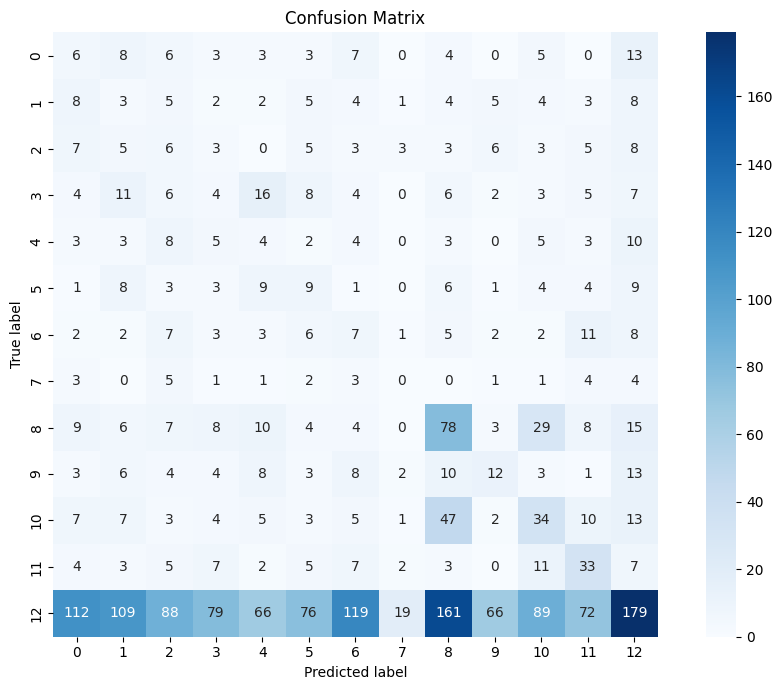

In [27]:
plt.figure(figsize=(10, 7))

# Draw the heatmap
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", square=True,
            xticklabels=range(np.unique(true_labels).size),
            yticklabels=range(np.unique(true_labels).size))

plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

# Show the plot
plt.show()

In [28]:
# F1 score and other metrics

precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f"Precision: {precision}, Recall: {recall}, F1: {f1}")




Precision: 0.39944023477791646, Recall: 0.1736111111111111, F1: 0.19874927010804727


In [ ]:
# Saving model

torch.save(model, f"saved_models/V{experiment_no}/model.pth")
with open(f"saved_models/V{experiment_no}/README.md","w") as f:
    f.write(f"Model details:\n")
    f.write(f"Train accuracy : {epoch_accuracy}\n")
    f.write(f"Test accuracy : {test_accuracy}\n")